In [1]:
import pandas as pd
import re
import textstat
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
df = pd.read_json('merger_data.json')


In [8]:
mergers = df.copy()
mergers.shape

(825773, 20)

Select industries with codes starting with 64,65,66,67,68,69 - Financial industries

In [ ]:
industries = pd.read_csv('industries.csv')

financial = industries[industries['code'].astype(str).str.startswith(('64', '65', '66', '67', '68', '69'))]

filtered_codes = financial['code'].tolist()

Convert datatype from the bidders industry column so I can match them and select only rows that interest me

In [ ]:
def convert_bidders_industry(value):
    if isinstance(value, list):
        if len(value) == 0:
            return np.nan  
        elif len(value) == 1:
            element = value[0]
            if element is not None and isinstance(element, (str, int, float)):
                try:
                    return int(float(element))  
                except ValueError:
                    return np.nan  
            else:
                return np.nan 
    return np.nan  

mergers['bidders_industry'] = mergers['bidders_industry'].apply(convert_bidders_industry)

financial_mergers = mergers[mergers['bidders_industry'].isin(filtered_codes)]
print(financial_mergers.shape)

(122243, 20)


Select only bidders country US to further reduce number of rows
Select only rows where column 'bidders_isin' isn't None

In [ ]:
us_bidders = financial_mergers[financial_mergers['bidders_country'].apply(lambda x: 'US' in x if isinstance(x, list) else False)]

us_bidders = us_bidders[us_bidders['bidders_isin'].apply(lambda x: x != [None])]

us_bidders.shape

(9257, 20)

Calculate readability/complexity scores based on the comments column

In [ ]:
textstat_obj = textstat.textstat

def calculate_text_complexity(comment):
    fk_grade = textstat_obj.flesch_kincaid_grade(comment)  
    fk_reading_ease = textstat_obj.flesch_reading_ease(comment)  
    
    # Invert Flesch Reading Ease to align higher values with higher complexity
    inv_fk_reading_ease = 100 - fk_reading_ease  # Reading Ease ranges between 0-100
    
    avg_syllables = np.mean([textstat_obj.syllable_count(word) for word in comment.split()]) if comment.split() else 0
    
    return fk_grade, inv_fk_reading_ease, avg_syllables

complexity_scores = us_bidders['comments'].apply(calculate_text_complexity)

us_bidders[['fk_grade', 'inv_fk_reading_ease', 'avg_syllables']] = pd.DataFrame(complexity_scores.tolist(), index=us_bidders.index)

us_bidders[['comments', 'fk_grade', 'inv_fk_reading_ease', 'avg_syllables']].head()

,comments,fk_grade,inv_fk_reading_ease,avg_syllables
492,2010-09-08: Southern Trust Securities Holding ...,6.6,26.42,1.407942
1396,"2004-07-21: Mr Lawrence (Bud) Stumbaugh, Presi...",13.0,80.77,2.102041
2669,2023-07-20: it was announced that Oconee Feder...,9.6,55.70,1.814815
2715,2017-05-01: it was announced that on 25/04/17 ...,11.0,48.62,1.571429
2809,2009-07-07: Schneider Logistics Inc. announced...,6.9,37.96,1.600000


Normalise the columns so they are on the same scale and can be somewhat comparable and create complexity column which is just mean of the 3 calculated ones

In [ ]:
scaler = MinMaxScaler()

columns_to_normalize = ['fk_grade', 'inv_fk_reading_ease', 'avg_syllables']

us_bidders.loc[:, columns_to_normalize] = scaler.fit_transform(us_bidders[columns_to_normalize])

us_bidders = us_bidders.copy()
us_bidders.loc[:, 'complexity'] = us_bidders[columns_to_normalize].mean(axis=1)

us_bidders = us_bidders[us_bidders['complexity'] != 0]

us_bidders[['comments', 'fk_grade', 'inv_fk_reading_ease', 'avg_syllables', 'complexity']].head(5)

,comments,fk_grade,inv_fk_reading_ease,avg_syllables,complexity
492,2010-09-08: Southern Trust Securities Holding ...,0.477516,0.604875,0.588128,0.556840
1396,"2004-07-21: Mr Lawrence (Bud) Stumbaugh, Presi...",0.614561,0.851573,0.878068,0.781400
2669,2023-07-20: it was announced that Oconee Feder...,0.541756,0.737779,0.758087,0.679207
2715,2017-05-01: it was announced that on 25/04/17 ...,0.571734,0.705642,0.656420,0.644599
2809,2009-07-07: Schneider Logistics Inc. announced...,0.483940,0.657256,0.668354,0.603183


In [ ]:
scaler = MinMaxScaler()

us_bidders = us_bidders.copy()

us_bidders.loc[:, 'normalized_complexity'] = scaler.fit_transform(us_bidders[['complexity']])

print(us_bidders['complexity'].describe())

count    9186.000000
mean        0.647077
std         0.053195
min         0.489245
25%         0.611040
50%         0.644219
75%         0.679204
max         0.915003
Name: complexity, dtype: float64


Create a column with text length of the comments column

In [ ]:
us_bidders = us_bidders.copy()

def calculate_text_length(comment):
    return len(comment.split())

us_bidders.loc[:, 'text_length'] = us_bidders['comments'].apply(calculate_text_length)
us_bidders['text_length'].describe()

count    9186.000000
mean      111.734487
std       118.459506
min         7.000000
25%        40.000000
50%        70.000000
75%       137.000000
max      2286.000000
Name: text_length, dtype: float64

Plot and calculate the relationship between text length and complexity

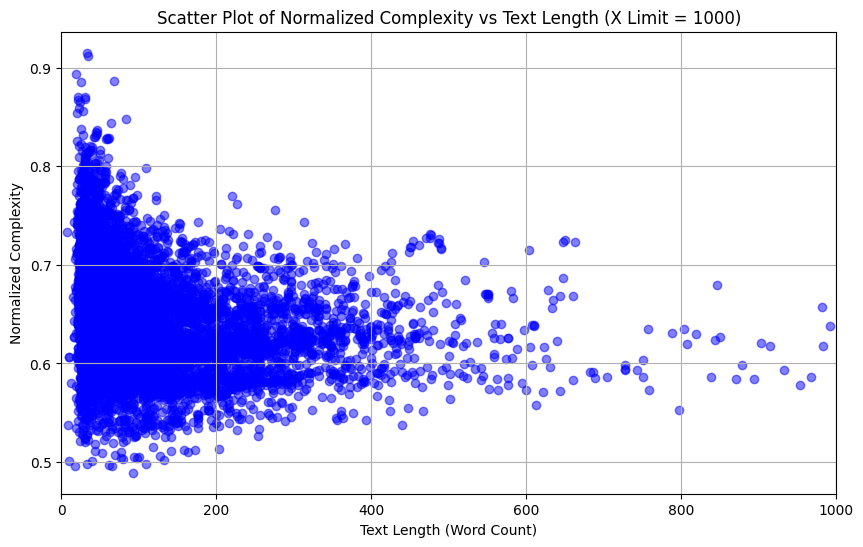

Spearman Correlation: -0.3275538015712322
Pearson Correlation: -0.2344744717750397


In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(us_bidders['text_length'], us_bidders['complexity'], alpha=0.5, color='blue')

plt.xlim(0, 1000)

plt.title('Scatter Plot of Normalized Complexity vs Text Length (X Limit = 1000)')
plt.ylabel('Normalized Complexity')
plt.xlabel('Text Length (Word Count)')
plt.grid(True)
plt.show()

pearson_corr = us_bidders['text_length'].corr(us_bidders['complexity'], method='pearson')
spearman_corr = us_bidders['text_length'].corr(us_bidders['complexity'], method='spearman')

print(f"Spearman Correlation: {spearman_corr}")
print(f"Pearson Correlation: {pearson_corr}")



In [18]:
#us_bidders_cleaned.head(2)
bidders_count = us_bidders['bidders_name'].value_counts()
bidders_count_is_in = us_bidders['bidders_isin'].value_counts()

In [19]:
bidders_count_is_in

bidders_isin
[US3635761097]    456
[US1152361010]    190
[US12504L1098]     97
[US63607P2083]     80
[US48020Q1076]     78
                 ... 
[US14912Y2028]      1
[US34619V1035]      1
[US67623C1099]      1
[US3514713052]      1
[US09623W1071]      1
Name: count, Length: 2255, dtype: int64

In [ ]:
unique_bidders_df = us_bidders[['bidders_name', 'bidders_isin']].drop_duplicates(subset='bidders_isin')

unique_bidders_df['bidders_name'].value_counts()

# Save the new DataFrame to a CSV file
#unique_bidders_df.to_csv('unique_bidders.csv', index=False)

#unique_bidders_df.value_counts()



Use the data that I downloaded using Refinitiv Eikon

In [ ]:
file_path = 'data_ps.xlsx'
sheets = pd.read_excel(file_path, sheet_name=None)

Load all the individual sheets

In [150]:
isin = sheets['isin,ric,name']
price = sheets['P']
price_in_dollars = sheets['P~U$']
return_index = sheets['RI']
ps = sheets['P#S']
earnings_per_share = sheets['EPS']
dividend_yield = sheets['DY']
dividend_per_share = sheets['DPS']

Work with return index data so it's compatible

In [151]:
return_index['Name_cleaned'] = return_index['Name'].str.replace(r' - TOT RETURN IND$', '', regex=True)
return_index.shape
#return_index.loc[1,'Name']

(2255, 2612)

Merge RI and ISIN dataframes and cleanup

In [ ]:
ri = pd.merge(return_index, isin, left_on='Name_cleaned', right_on='NAME', how='inner')

columns = ['Type'] + [col for col in ri.columns if col != 'Type']
ri = ri[columns]


In [ ]:
ri = ri.drop(columns=['Name', 'Name_cleaned', 'RIC'])

ri = ri[['NAME'] + [col for col in ri.columns if col != 'NAME']]

In [ ]:
ri = ri.rename(columns={'Type': 'ISIN'})

In [155]:
columns_to_chose = ['bidders_isin', 'complexity', 'text_length', 'date_rumor', 'date_announcement']
merging_df = us_bidders[columns_to_chose]
merging_df.rename(columns={'bidders_isin':'ISIN'}, inplace=True)

C:\Users\pavle\AppData\Local\Temp\ipykernel_16568\209465955.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merging_df.rename(columns={'bidders_isin':'ISIN'}, inplace=True)


In [156]:
merging_df.shape

(9186, 5)

Work with datatypes so it matches

In [ ]:
ri['ISIN'] = ri['ISIN'].astype(str)
merging_df['ISIN'] = merging_df['ISIN'].astype(str)

# Clean the ISIN column in merging_df by stripping characters and removing quotes
merging_df['ISIN'] = merging_df['ISIN'].str.strip("[]").str.replace("'", "")

merged_df = pd.merge(merging_df, ri, on='ISIN', how='inner')

merged_df = merged_df.drop(columns=merged_df.columns[-1])


C:\Users\pavle\AppData\Local\Temp\ipykernel_16568\3404886722.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merging_df['ISIN'] = merging_df['ISIN'].astype(str)
C:\Users\pavle\AppData\Local\Temp\ipykernel_16568\3404886722.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merging_df['ISIN'] = merging_df['ISIN'].str.strip("[]").str.replace("'", "")


In [ ]:
date_columns = merged_df.columns[6:]  # Date columns are from index 6 onwards

date_columns = pd.to_datetime(date_columns).date

merged_df.columns = list(merged_df.columns[:6]) + list(date_columns)

In [ ]:
price_columns = merged_df.columns[6:]
merged_df['date_rumor'] = pd.to_datetime(merged_df['date_rumor'])
merged_df['date_announcement'] = pd.to_datetime(merged_df['date_announcement'])

merged_df[price_columns] = merged_df[price_columns].apply(pd.to_numeric, errors='coerce')

merged_df[price_columns] = merged_df[price_columns].astype(float)

Drop all mergers where the price is unavailable or the rumor date is before 2015

In [ ]:
date_columns = merged_df.columns[6:]

merged_df = merged_df[~(merged_df[date_columns] == 0).all(axis=1)]

merged_df = merged_df[merged_df['date_rumor'] >= '2015-11-27']

merged_df.shape


(2340, 2615)

In [161]:
merged_df[price_columns] = merged_df[price_columns].apply(pd.to_numeric, errors='coerce')

In [162]:
print(merged_df[price_columns].isna().sum())  # Check before pct_change


2014-11-27    623
2014-11-28    623
2014-12-01    623
2014-12-02    623
2014-12-03    623
             ... 
2024-11-20      0
2024-11-21      0
2024-11-22      0
2024-11-25      0
2024-11-26      0
Length: 2609, dtype: int64


In [ ]:
threshold = len(price_columns) * 0.3  # At least 30% of columns must be non-NaN
merged_df.dropna(thresh=threshold, subset=price_columns, inplace=True)

Compute logarithmic returns

In [ ]:
merged_df[price_columns] = merged_df[price_columns].apply(pd.to_numeric, errors='coerce')

log_returns = np.log(merged_df[price_columns].pct_change(axis=1) + 1)

merged_df[price_columns] = log_returns

threshold = len(price_columns) * 0.3  # Keep rows with at least 30% valid data
merged_df.dropna(thresh=threshold, subset=price_columns, inplace=True)

C:\Users\pavle\AppData\Local\Temp\ipykernel_16568\3872413496.py:5: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  log_returns = np.log(merged_df[price_columns].pct_change(axis=1) + 1)
c:\Users\pavle\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\internals\blocks.py:366: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


,ISIN,complexity,text_length,date_rumor,date_announcement,NAME,2014-11-27,2014-11-28,2014-12-01,2014-12-02,...,2024-11-13,2024-11-14,2024-11-15,2024-11-18,2024-11-19,2024-11-20,2024-11-21,2024-11-22,2024-11-25,2024-11-26
6,US6756071055,0.679207,81,2023-07-20,2023-07-20,OCONEE FED FINL,NaN,0.002679,0.004204,0.000000,...,0.0000,0.000000,0.0000,-0.006676,0.076823,-0.069357,0.000000,0.000000,0.071443,0.000000
8,US42981W1045,0.644599,119,2017-04-25,2017-04-25,HIGH WIRE NETWORKS,NaN,-0.177931,0.108849,0.048879,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,US3020811044,0.707324,39,2016-02-12,NaT,EXLSERVICE HDG.,NaN,-0.002819,-0.020576,0.005815,...,-0.0142,-0.016162,-0.0162,-0.007634,-0.001582,0.002252,0.028434,0.011976,0.012044,0.005335
20,US3020811044,0.605777,45,2016-07-06,2016-07-06,EXLSERVICE HDG.,NaN,-0.002819,-0.020576,0.005815,...,-0.0142,-0.016162,-0.0162,-0.007634,-0.001582,0.002252,0.028434,0.011976,0.012044,0.005335
21,US3020811044,0.639080,29,2016-10-27,2016-10-27,EXLSERVICE HDG.,NaN,-0.002819,-0.020576,0.005815,...,-0.0142,-0.016162,-0.0162,-0.007634,-0.001582,0.002252,0.028434,0.011976,0.012044,0.005335


Drop rows where 75% or more values are NaN or 0

In [ ]:
invalid_threshold = len(price_columns) * 0.75
merged_df = merged_df[((merged_df[price_columns].isna()) | (merged_df[price_columns] == 0)).sum(axis=1) < invalid_threshold]

merged_df


,ISIN,complexity,text_length,date_rumor,date_announcement,NAME,2014-11-27,2014-11-28,2014-12-01,2014-12-02,...,2024-11-13,2024-11-14,2024-11-15,2024-11-18,2024-11-19,2024-11-20,2024-11-21,2024-11-22,2024-11-25,2024-11-26
6,US6756071055,0.679207,81,2023-07-20,2023-07-20,OCONEE FED FINL,NaN,0.002679,0.004204,0.000000,...,0.000000,0.000000,0.000000,-0.006676,0.076823,-0.069357,0.000000,0.000000,0.071443,0.000000
8,US42981W1045,0.644599,119,2017-04-25,2017-04-25,HIGH WIRE NETWORKS,NaN,-0.177931,0.108849,0.048879,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,US3020811044,0.707324,39,2016-02-12,NaT,EXLSERVICE HDG.,NaN,-0.002819,-0.020576,0.005815,...,-0.014200,-0.016162,-0.016200,-0.007634,-0.001582,0.002252,0.028434,0.011976,0.012044,0.005335
20,US3020811044,0.605777,45,2016-07-06,2016-07-06,EXLSERVICE HDG.,NaN,-0.002819,-0.020576,0.005815,...,-0.014200,-0.016162,-0.016200,-0.007634,-0.001582,0.002252,0.028434,0.011976,0.012044,0.005335
21,US3020811044,0.639080,29,2016-10-27,2016-10-27,EXLSERVICE HDG.,NaN,-0.002819,-0.020576,0.005815,...,-0.014200,-0.016162,-0.016200,-0.007634,-0.001582,0.002252,0.028434,0.011976,0.012044,0.005335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9059,US69360N1081,0.641179,58,2020-12-16,2020-12-16,PSB HOLDINGS,NaN,0.000000,0.000000,0.000000,...,0.000372,0.003729,0.022052,0.000000,0.000000,0.014448,0.000000,0.000000,0.000000,0.000000
9065,US2039161011,0.619895,173,2020-10-12,2020-10-12,COMMUNITY FIRST BANCORP DEAD - DELIST.01/08/24,NaN,0.000000,-0.032894,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9072,US6801941070,0.602392,146,2017-10-30,2017-10-30,OLD POINT FINANCIAL,NaN,0.000000,0.003336,0.000000,...,-0.005998,-0.008704,0.000991,-0.001953,-0.014662,0.005903,0.017472,0.041002,0.007838,0.010028
9081,US00037T1034,0.520543,79,2021-07-14,NaT,AAP,NaN,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.287682,-0.287682,0.000000,0.000000,0.000000,0.000000,0.000000


Calculating normal and abnormal returns

In [ ]:
from sklearn.linear_model import LinearRegression

merged_df.columns = merged_df.columns.astype(str)
date_columns = pd.to_datetime(merged_df.columns[6:], errors='coerce')

merged_df['normal_returns'] = None
merged_df['abnormal_returns'] = None

for i, row in merged_df.iterrows():
    date_rumor = pd.to_datetime(row['date_rumor'])

    estimation_end = date_rumor - pd.Timedelta(days=10)
    estimation_start = date_rumor - pd.Timedelta(days=110)
    event_start = date_rumor - pd.Timedelta(days=0)
    event_end = date_rumor + pd.Timedelta(days=7)

    # Find the nearest previous trading day for estimation_end and estimation_start
    estimation_end = date_columns[date_columns <= estimation_end].max()
    estimation_start = date_columns[date_columns <= estimation_start].max()

    # Find the nearest previous trading day for event_start and the nearest next trading day for event_end
    event_start = date_columns[date_columns <= event_start].max()
    event_end = date_columns[date_columns >= event_end].min()

    estimation_dates = date_columns[(date_columns >= estimation_start) & (date_columns <= estimation_end)]
    event_dates = date_columns[(date_columns >= event_start) & (date_columns <= event_end)]

    estimation_dates_str = estimation_dates.strftime('%Y-%m-%d')
    event_dates_str = event_dates.strftime('%Y-%m-%d')

    estimation_period = row[estimation_dates_str].dropna()

    event_period = row[event_dates_str].dropna()

    if len(estimation_period) < 2 or len(event_period) < 1:
        # print(f"Not enough data for regression for row {i}. Skipping.")
        continue

    X_estimation = np.arange(len(estimation_period)).reshape(-1, 1)
    y_estimation = estimation_period.values

    model = LinearRegression().fit(X_estimation, y_estimation)

    X_event = np.arange(len(estimation_period), len(estimation_period) + len(event_period)).reshape(-1, 1)
    normal_returns = model.predict(X_event)

    abnormal_returns = event_period.values - normal_returns

    merged_df.at[i, 'normal_returns'] = normal_returns.tolist()
    merged_df.at[i, 'abnormal_returns'] = abnormal_returns.tolist()


merged_df[['normal_returns', 'abnormal_returns']]

C:\Users\pavle\AppData\Local\Temp\ipykernel_16568\382707322.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['normal_returns'] = None
C:\Users\pavle\AppData\Local\Temp\ipykernel_16568\382707322.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['abnormal_returns'] = None


,normal_returns,abnormal_returns
6,"[-0.00530858684691261, -0.005377092941296572, ...","[-0.041545723579094765, 0.03137837156884793, -..."
8,"[0.026731076913451276, 0.027327129164026184, 0...","[-0.10454809927025904, 0.10258500507618332, 0...."
19,"[-0.00314675231663423, -0.003268220421828614, ...","[0.0013409992140671915, 0.003268220421828614, ..."
20,"[0.0010211521753412003, 0.0010287906818540178,...","[0.002863757857335219, 0.001251546927400513, 0..."
21,"[-0.001549801639959009, -0.001564560695363799,...","[-0.04411195995271133, -0.004732343365193393, ..."
...,...,...
9059,"[0.009576950823102377, 0.009771647679421092, 0...","[-0.009576950823102377, -0.009771647679421092,..."
9065,"[0.001030789025263469, 0.001074500420114212, 0...","[0.04728705161981307, -0.001074500420114212, -..."
9072,"[0.004633989061859622, 0.004758141293277884, 0...","[-0.0015062397453493213, 0.003911711701263945,..."
9081,"[0.02355459624709195, 0.024143154025312513, 0....","[-0.27958783556637995, 0.08569647947703472, -0..."


In [ ]:
merged_df['CAR'] = None

for i, row in merged_df.iterrows():
    abnormal_returns = row['abnormal_returns']
    
    if abnormal_returns:
        car = np.sum(abnormal_returns)
        merged_df.at[i, 'CAR'] = car

# Display the updated DataFrame with CAR
merged_df[['text_length', 'complexity', 'CAR']]


C:\Users\pavle\AppData\Local\Temp\ipykernel_16568\330764163.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['CAR'] = None


,text_length,complexity,CAR
6,81,0.679207,-0.018007
8,119,0.644599,-0.048578
19,39,0.707324,0.027978
20,45,0.605777,0.039792
21,29,0.639080,-0.049885
...,...,...,...
9059,58,0.641179,-0.075043
9065,173,0.619895,0.043187
9072,146,0.602392,-0.020947
9081,79,0.520543,-0.69078


In [ ]:
def convert_columns_to_numeric(df, columns):
    for col in columns:
        if isinstance(df[col].iloc[0], list):
            df[col] = df[col].apply(lambda x: np.mean(x) if isinstance(x, list) else x)
            
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    return df


columns_to_check = ['text_length', 'complexity', 'abnormal_returns', 'CAR']
merged_df_cleaned = convert_columns_to_numeric(merged_df.copy(), columns_to_check)

def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

merged_df_cleaned = remove_outliers(merged_df_cleaned, columns_to_check)

merged_df_cleaned.dropna(subset=['abnormal_returns', 'text_length', 'complexity'], inplace=True)

X = merged_df_cleaned[['text_length', 'complexity']]
X = sm.add_constant(X) 
y = merged_df_cleaned['abnormal_returns']  # or 'CAR'

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

import statsmodels.api as sm
model = sm.OLS(y_train, X_train)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       abnormal_returns   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     4.392
Date:                Sat, 30 Nov 2024   Prob (F-statistic):             0.0126
Time:                        20:03:03   Log-Likelihood:                 3738.7
No. Observations:                1072   AIC:                            -7471.
Df Residuals:                    1069   BIC:                            -7456.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0009      0.004      0.251      

In [ ]:
p_values = results.pvalues

p_value_text_length = p_values['text_length']
p_value_complexity = p_values['complexity']

print(f"P-value for text_length: {p_value_text_length}")
print(f"P-value for complexity: {p_value_complexity}")

P-value for text_length: 0.044801750471214236
P-value for complexity: 0.8281466100609389


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

model_rf = RandomForestRegressor(n_estimators=100, random_state=1)
model_rf.fit(X_train, y_train)

y_pred_rf = model_rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_rf)
mse = mean_squared_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared: {r2}")

importances = model_rf.feature_importances_
feature_names = X.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importance_df)


Mean Absolute Error (MAE): 0.007497475204626804
Mean Squared Error (MSE): 8.929467431739495e-05
R-squared: -0.20023856277694008

Feature Importances:
       Feature  Importance
2   complexity    0.590658
1  text_length    0.409342
0        const    0.000000


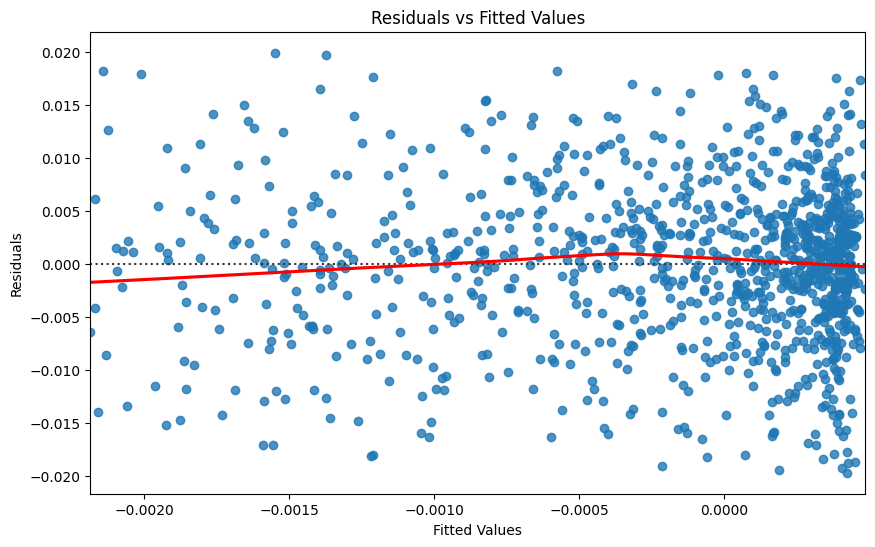

In [ ]:
import seaborn as sns

residuals = results.resid

# Residuals vs Fitted Plot (for Homoscedasticity)
plt.figure(figsize=(10, 6))
sns.residplot(x=results.fittedvalues, y=residuals, lowess=True, line_kws={'color': 'red'})
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()



In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)

      Variable         VIF
0        const  241.914954
1  text_length    1.145030
2   complexity    1.145030
